# Лабораторная работа 1. Интерполяция Лагранжа и кусочная интерполяция.

## Импорт библиотек и описание необходимых функций и переменных.

### Импорт:

In [251]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import derivative
from scipy.special import erf

### Общие параметры:

In [252]:
interval_start = -5.
interval_end = 5.
plot_nodes_count = 200

nodes_left_boundary = 4
nodes_right_boundary = 21

figsize_standart = (8, 6)
dpi_standart = 300
linewidth_standart = 1.0
bbox_to_anchor_standart = (1.05, 1)
cmap_name_standart = 'winter'
dx_standart = 1e-1

err_interval_start = -2.
err_interval_end = 2.
err_x_nodes_count = int(np.abs(err_interval_start - err_interval_end) * plot_nodes_count
                        / np.abs(interval_start - interval_end))
N_err = [3, 5, 7, 9]
N_err_special = range(3, 10)

### Функция для нахождения i-го базисного полинома Лагранжа:

In [253]:
def l_i(i, x, x_nodes):
    li = 1
    
    for j in range(len(x_nodes)):
        if j != (i - 1):
            li *= (x - x_nodes[j]) / (x_nodes[i - 1] - x_nodes[j])
    return li

### Функция для нахождения интерполяционного полинома Лагранжа

In [254]:
def L(x, x_nodes, y_nodes):
    Lx = 0
    
    for i in range(len(x_nodes)):
        Lx += y_nodes[i] * l_i(i + 1, x, x_nodes)
    return Lx

### Функция для кусочно-линейной интерполяции:

In [255]:
def f_piece_lin(x, x_nodes, y_nodes):
    for i in range(1, len(x_nodes)):
        if (x_nodes[i - 1] <= x <= x_nodes[i]):
            a0 = (y_nodes[i] - y_nodes[i - 1]) / (x_nodes[i] - x_nodes[i - 1])
            a1 = y_nodes[i - 1] - a0 * x_nodes[i - 1]

            return (a0 * x + a1)
        
    return None

### Заданная функция:

In [256]:
def f(x):
    return np.exp(-x**2)

### Вспомогательная функция для пересчета значений оптимальных узлов на произвольном отрезке:

In [257]:
def translate_to_interval(x, start, end):
    return 0.5 * ( (end - start) * x + start + end )

### Вспомогательная функция для нахождения производной функции:

In [258]:
def nth_derivative(f, n, x):
    if (n % 2 == 0):
        derivative_order = n + 1
    else:
        derivative_order = n + 2
        
    nth_derivative = derivative(f, x, dx=dx_standart, n=n, order=derivative_order)
    
    return nth_derivative

### Вспомогательная функция для нахождения оптимальных узлов:

In [259]:
def cheb_nodes(start, end, n):
    x_cheb = np.array([])
    
    for k in range(n):
        x_cheb = np.append(x_cheb,
                  translate_to_interval(
                    np.cos( (2 * (k + 1) - 1) * np.pi / (2 * n) ),
                    start, end))
    return x_cheb

### Функция для нахождения остаточного члена в случае равномерно распределенных узлов:

In [260]:
def rem_evenly(x, x_nodes):
    rem_evenly = 0
    n = len(x_nodes)
    x_len = len(x)
    
    if 0 not in x:
        x = np.append(x, 0)
        
    nth_derivative_vec = np.vectorize(nth_derivative, excluded=['f', 'n'])
    derivatives_array = np.abs(nth_derivative(f=f, n=n, x=x))
    
    mult_array = np.array([])
    for i in range(x_len):
        mult = 1
        for j in range(n):
            mult *= (x[i] - x_nodes[j])
        mult_array = np.append(mult_array, np.abs(mult))
        
    rem_evenly = (np.max(derivatives_array) / np.math.factorial(n)) * np.max(mult_array)
        
    return rem_evenly

### Функция для нахождения остаточного члена в случае равномерно оптимально узлов:

In [261]:
def rem_cheb(x, x_nodes):
    n = len(x_nodes)
    
    if 0 not in x:
        x = np.append(x, 0)
    
    nth_derivative_vec = np.vectorize(nth_derivative, excluded=['f', 'n'])
    derivatives_array = nth_derivative(f=f, n=n, x=x)
    
    rem_cheb = np.max(derivatives_array) / ( 2**(n - 1) * (np.math.factorial(n)))
    
    return rem_cheb

### Функция для нахождения остаточного члена в случае кусочно-линейной интерполяции:

In [262]:
def rem_piece_lin(x, x_nodes):
    n = len(x_nodes)
    
    nth_derivative_vec = np.vectorize(nth_derivative, excluded=['f', 'n'])
    derivatives_array = nth_derivative(f=f, n=2, x=x)
    
    h = (x_nodes[0] - x_nodes[-1]) / (n - 1)
    
    rem_piece_lin = (np.max(derivatives_array) * h**2) / 8 
        
    return rem_piece_lin

### Вспомогательная функция для нахождения интеграла функции по заданным узлам и значениям функции:

In [263]:
def integral_trapeze(x_nodes, y_nodes):   
    res = 0
    for i in range(len(x_nodes) - 1):
        h = np.abs(x_nodes[i + 1] - x_nodes[i])
        res += ( (y_nodes[i] + y_nodes[i + 1]) * h)/ 2
        
    return res

### Функция для получения значений функции ошибок с использованием кусочно-линейной интерполяции:

In [264]:
def f_err_interp(n):
    x = np.linspace(err_interval_start, err_interval_end, err_x_nodes_count)
    
    x_nodes_evenly_distributed = np.linspace(err_interval_start, err_interval_end, n)
    y_nodes_evenly_distributed = f(x_nodes_evenly_distributed)
    
    y_nodes_piece_lin = f_piece_lin_vec(x=x, x_nodes=x_nodes_evenly_distributed,
                                        y_nodes=y_nodes_evenly_distributed)
    
    f_x_integral = integral_trapeze(x, y_nodes_piece_lin)
        
    return f_x_integral / np.sqrt(np.pi)

### Общие параметры и векторизация необходимых функций:

In [265]:
f_vec = np.vectorize(f)
L_vec = np.vectorize(L, excluded=['x_nodes', 'y_nodes'])
f_piece_lin_vec = np.vectorize(f_piece_lin, excluded=['x_nodes', 'y_nodes'])

x = np.linspace(interval_start, interval_end, plot_nodes_count)
fx_vec = f_vec(x)
N = np.arange(nodes_left_boundary, nodes_right_boundary)

## Случай равномерно распределенных узлов.

### Построение графиков заданной функции и интерполяционного полинома Лагранжа.

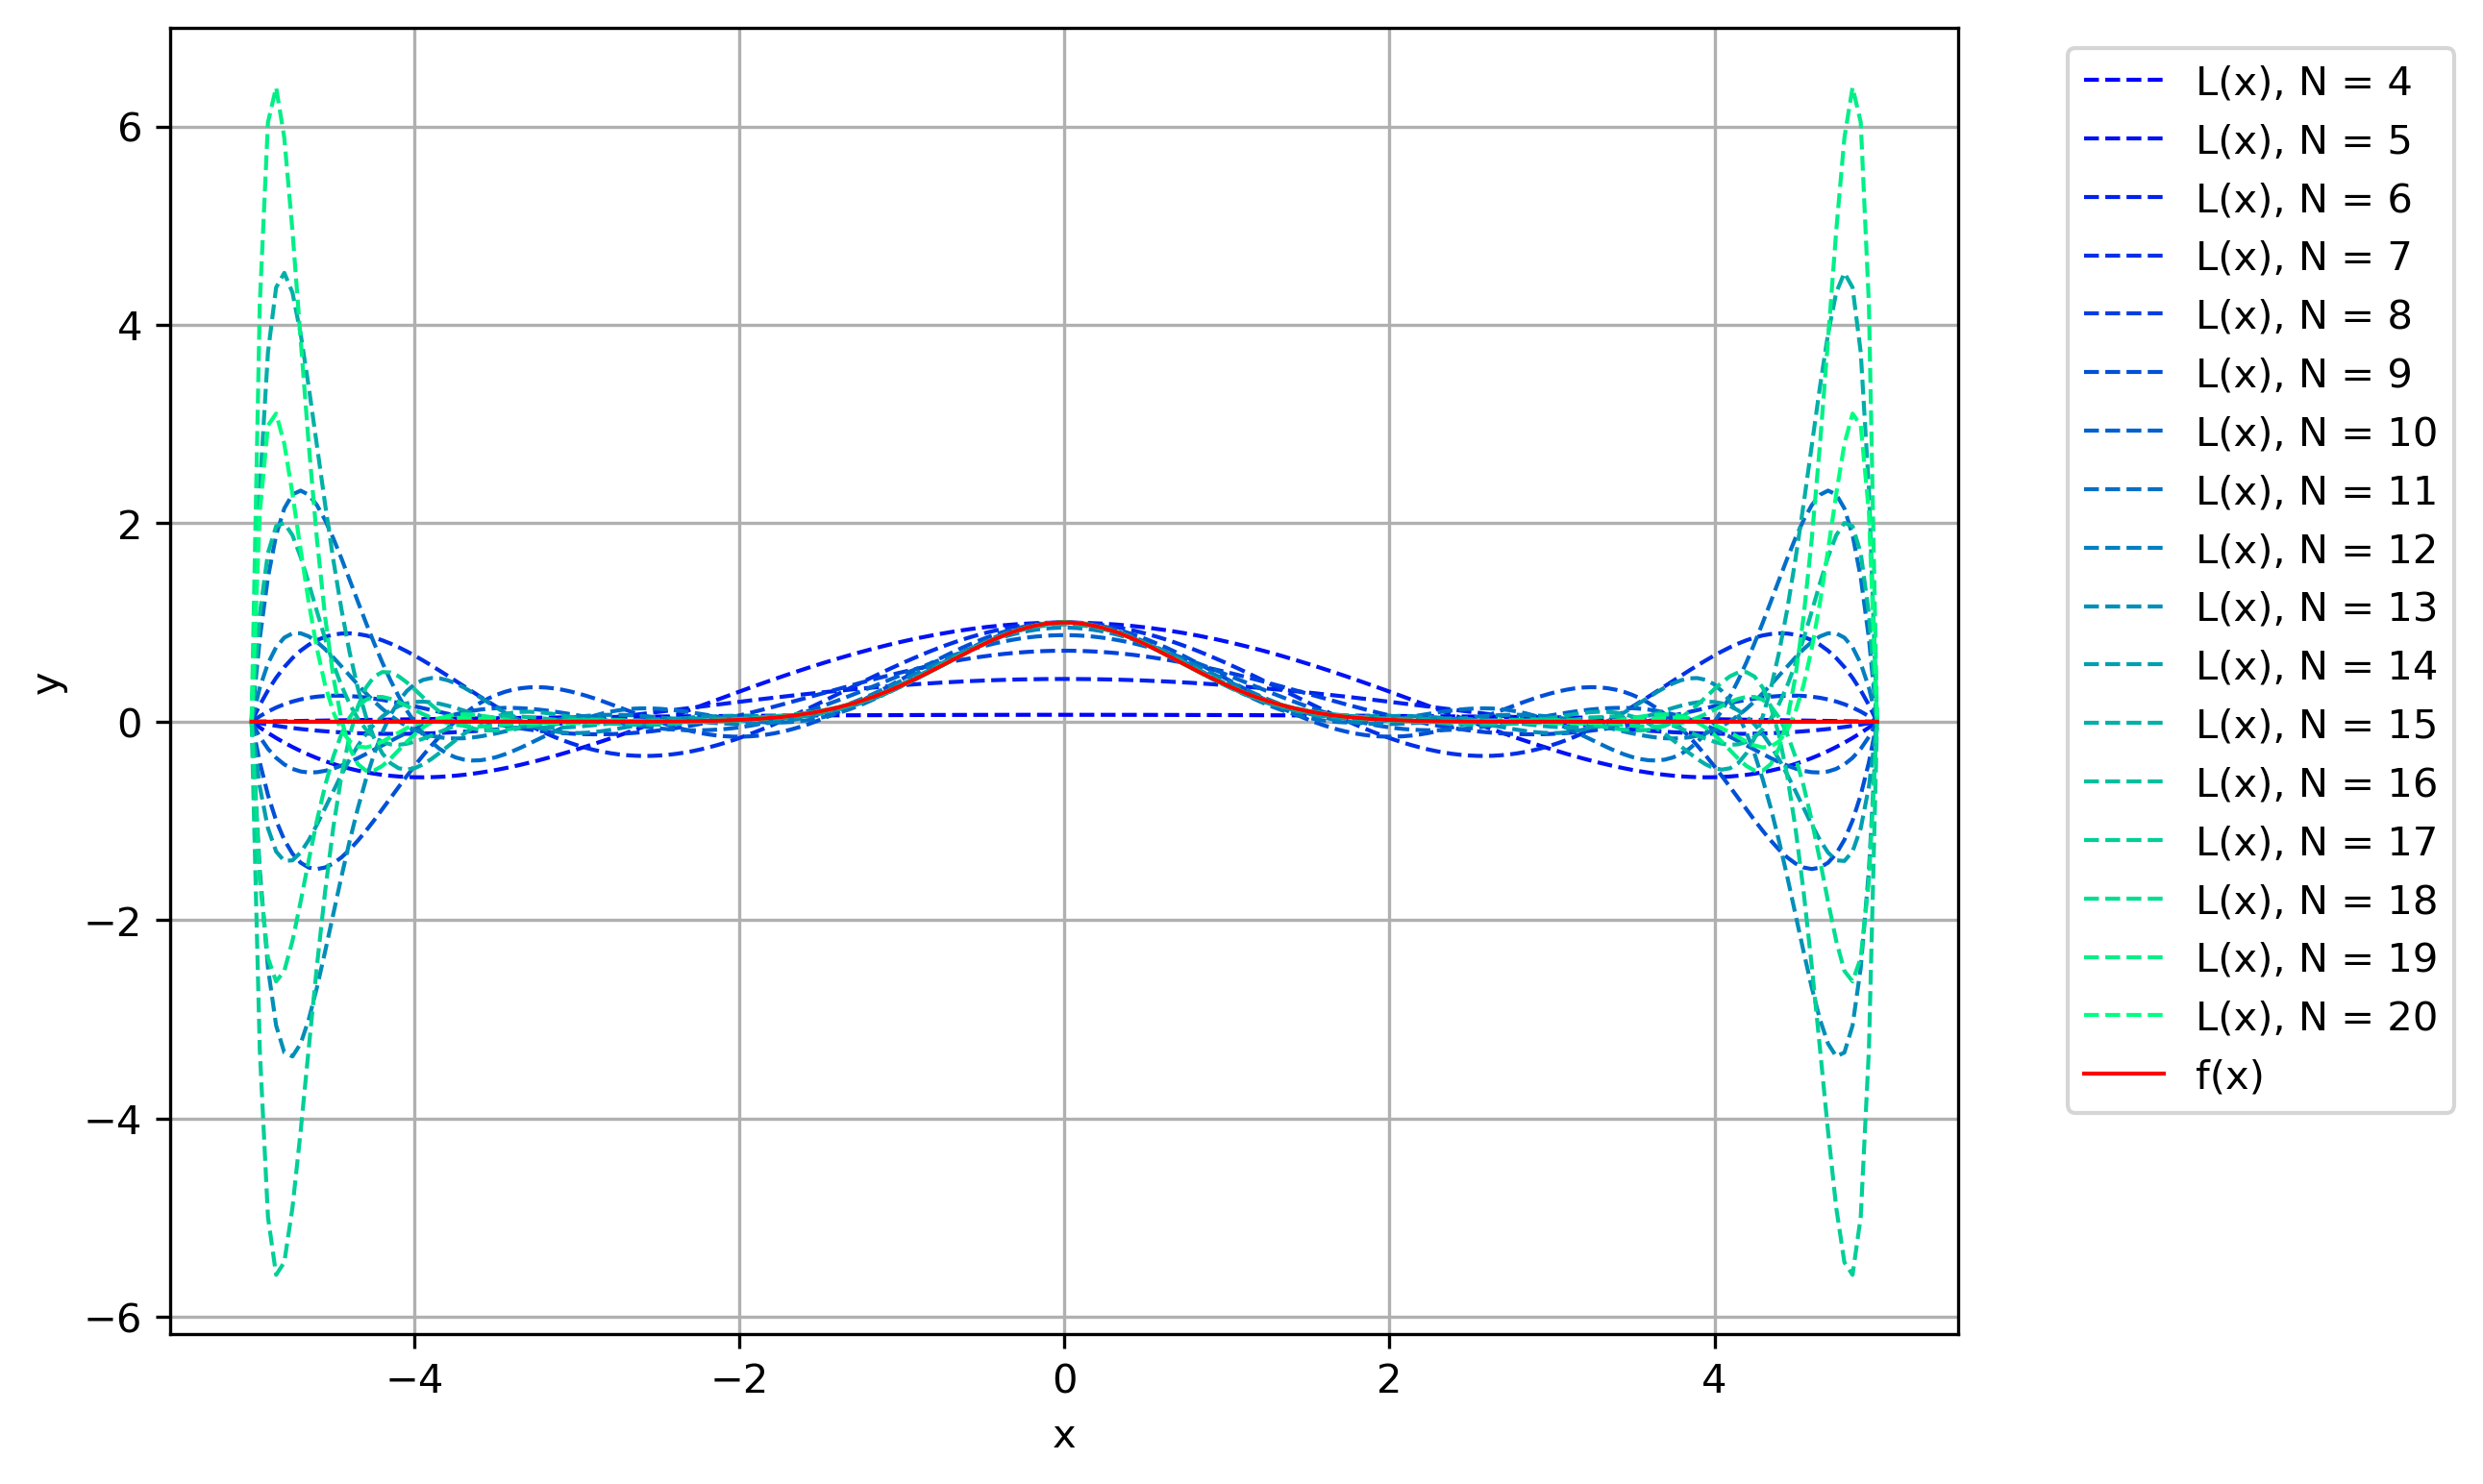

In [266]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)
cmap = plt.cm.get_cmap(cmap_name_standart, len(N))

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    y_nodes_evenly_distributed = f(x_nodes_evenly_distributed)
    
    axes.plot(x, L(x, x_nodes_evenly_distributed, y_nodes_evenly_distributed),
              color=cmap(n - nodes_left_boundary), linestyle='--',
              linewidth=linewidth_standart, label='L(x), N = {}'.format(n))
    
axes.plot(x, fx_vec, color="red", linewidth=linewidth_standart, label='f(x)')
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("x")
axes.set_ylabel("y")

plt.show()

### Нахождение расстояния между заданной функцией и полученным интерполяционным полиномом в лебеговом пространстве.

In [267]:
dist_evenly_array = np.array([])

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    y_nodes_evenly_distributed = f(x_nodes_evenly_distributed)
    
    distance = np.max(np.abs(fx_vec - L_vec(x=x, x_nodes=x_nodes_evenly_distributed,
                                        y_nodes=y_nodes_evenly_distributed)))

    dist_evenly_array = np.append(dist_evenly_array, distance)
                       
    print("Количество узлов = {}, расстояние = {}".format(n, distance))

Количество узлов = 4, расстояние = 0.9294220788474536
Количество узлов = 5, расстояние = 0.5600542274100669
Количество узлов = 6, расстояние = 0.5683253948585647
Количество узлов = 7, расстояние = 0.8908330341061284
Количество узлов = 8, расстояние = 0.2837229914568502
Количество узлов = 9, расстояние = 1.4846701970687846
Количество узлов = 10, расстояние = 0.5115106812959587
Количество узлов = 11, расстояние = 2.329393725056922
Количество узлов = 12, расстояние = 0.8915128269338115
Количество узлов = 13, расстояние = 3.3733850294241576
Количество узлов = 14, расстояние = 1.4033005137346821
Количество узлов = 15, расстояние = 4.523860399730428
Количество узлов = 16, расстояние = 2.003337276144759
Количество узлов = 17, расстояние = 5.574609161153755
Количество узлов = 18, расстояние = 2.617247888918776
Количество узлов = 19, расстояние = 6.393134128936814
Количество узлов = 20, расстояние = 3.105716396876675


### Оценка верхней границы зависимости погрешности интерполяции от количества узлов.

In [268]:
rem_evenly_array = np.array([])

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    
    rem_evenly_current = rem_evenly(x, x_nodes_evenly_distributed)
    rem_evenly_array = np.append(rem_evenly_array, rem_evenly_current)
    
    print("Количество узлов = {}, остаточный член = {}".format(n, rem_evenly_current))

Количество узлов = 4, остаточный член = 60.70242993826326
Количество узлов = 5, остаточный член = 92.80329065916017
Количество узлов = 6, остаточный член = 173.9952430783318
Количество узлов = 7, остаточный член = 255.33887692284702
Количество узлов = 8, остаточный член = 436.06104396227795
Количество узлов = 9, остаточный член = 594.2877941466232
Количество узлов = 10, остаточный член = 932.9362913853511
Количество узлов = 11, остаточный член = 1194.2309387607263
Количество узлов = 12, остаточный член = 1736.6976644711929
Количество узлов = 13, остаточный член = 2058.287424122067
Количество узлов = 14, остаточный член = 2821.5361158038295
Количество узлов = 15, остаточный член = 3174.2460933919547
Количество узлов = 16, остаточный член = 4023.420603649793
Количество узлов = 17, остаточный член = 4308.592190758538
Количество узлов = 18, остаточный член = 5249.129196760865
Количество узлов = 19, остаточный член = 5234.9505518034875
Количество узлов = 20, остаточный член = 6038.401410110

### Сравнение полученных расстояния и верхней границы зависимости.

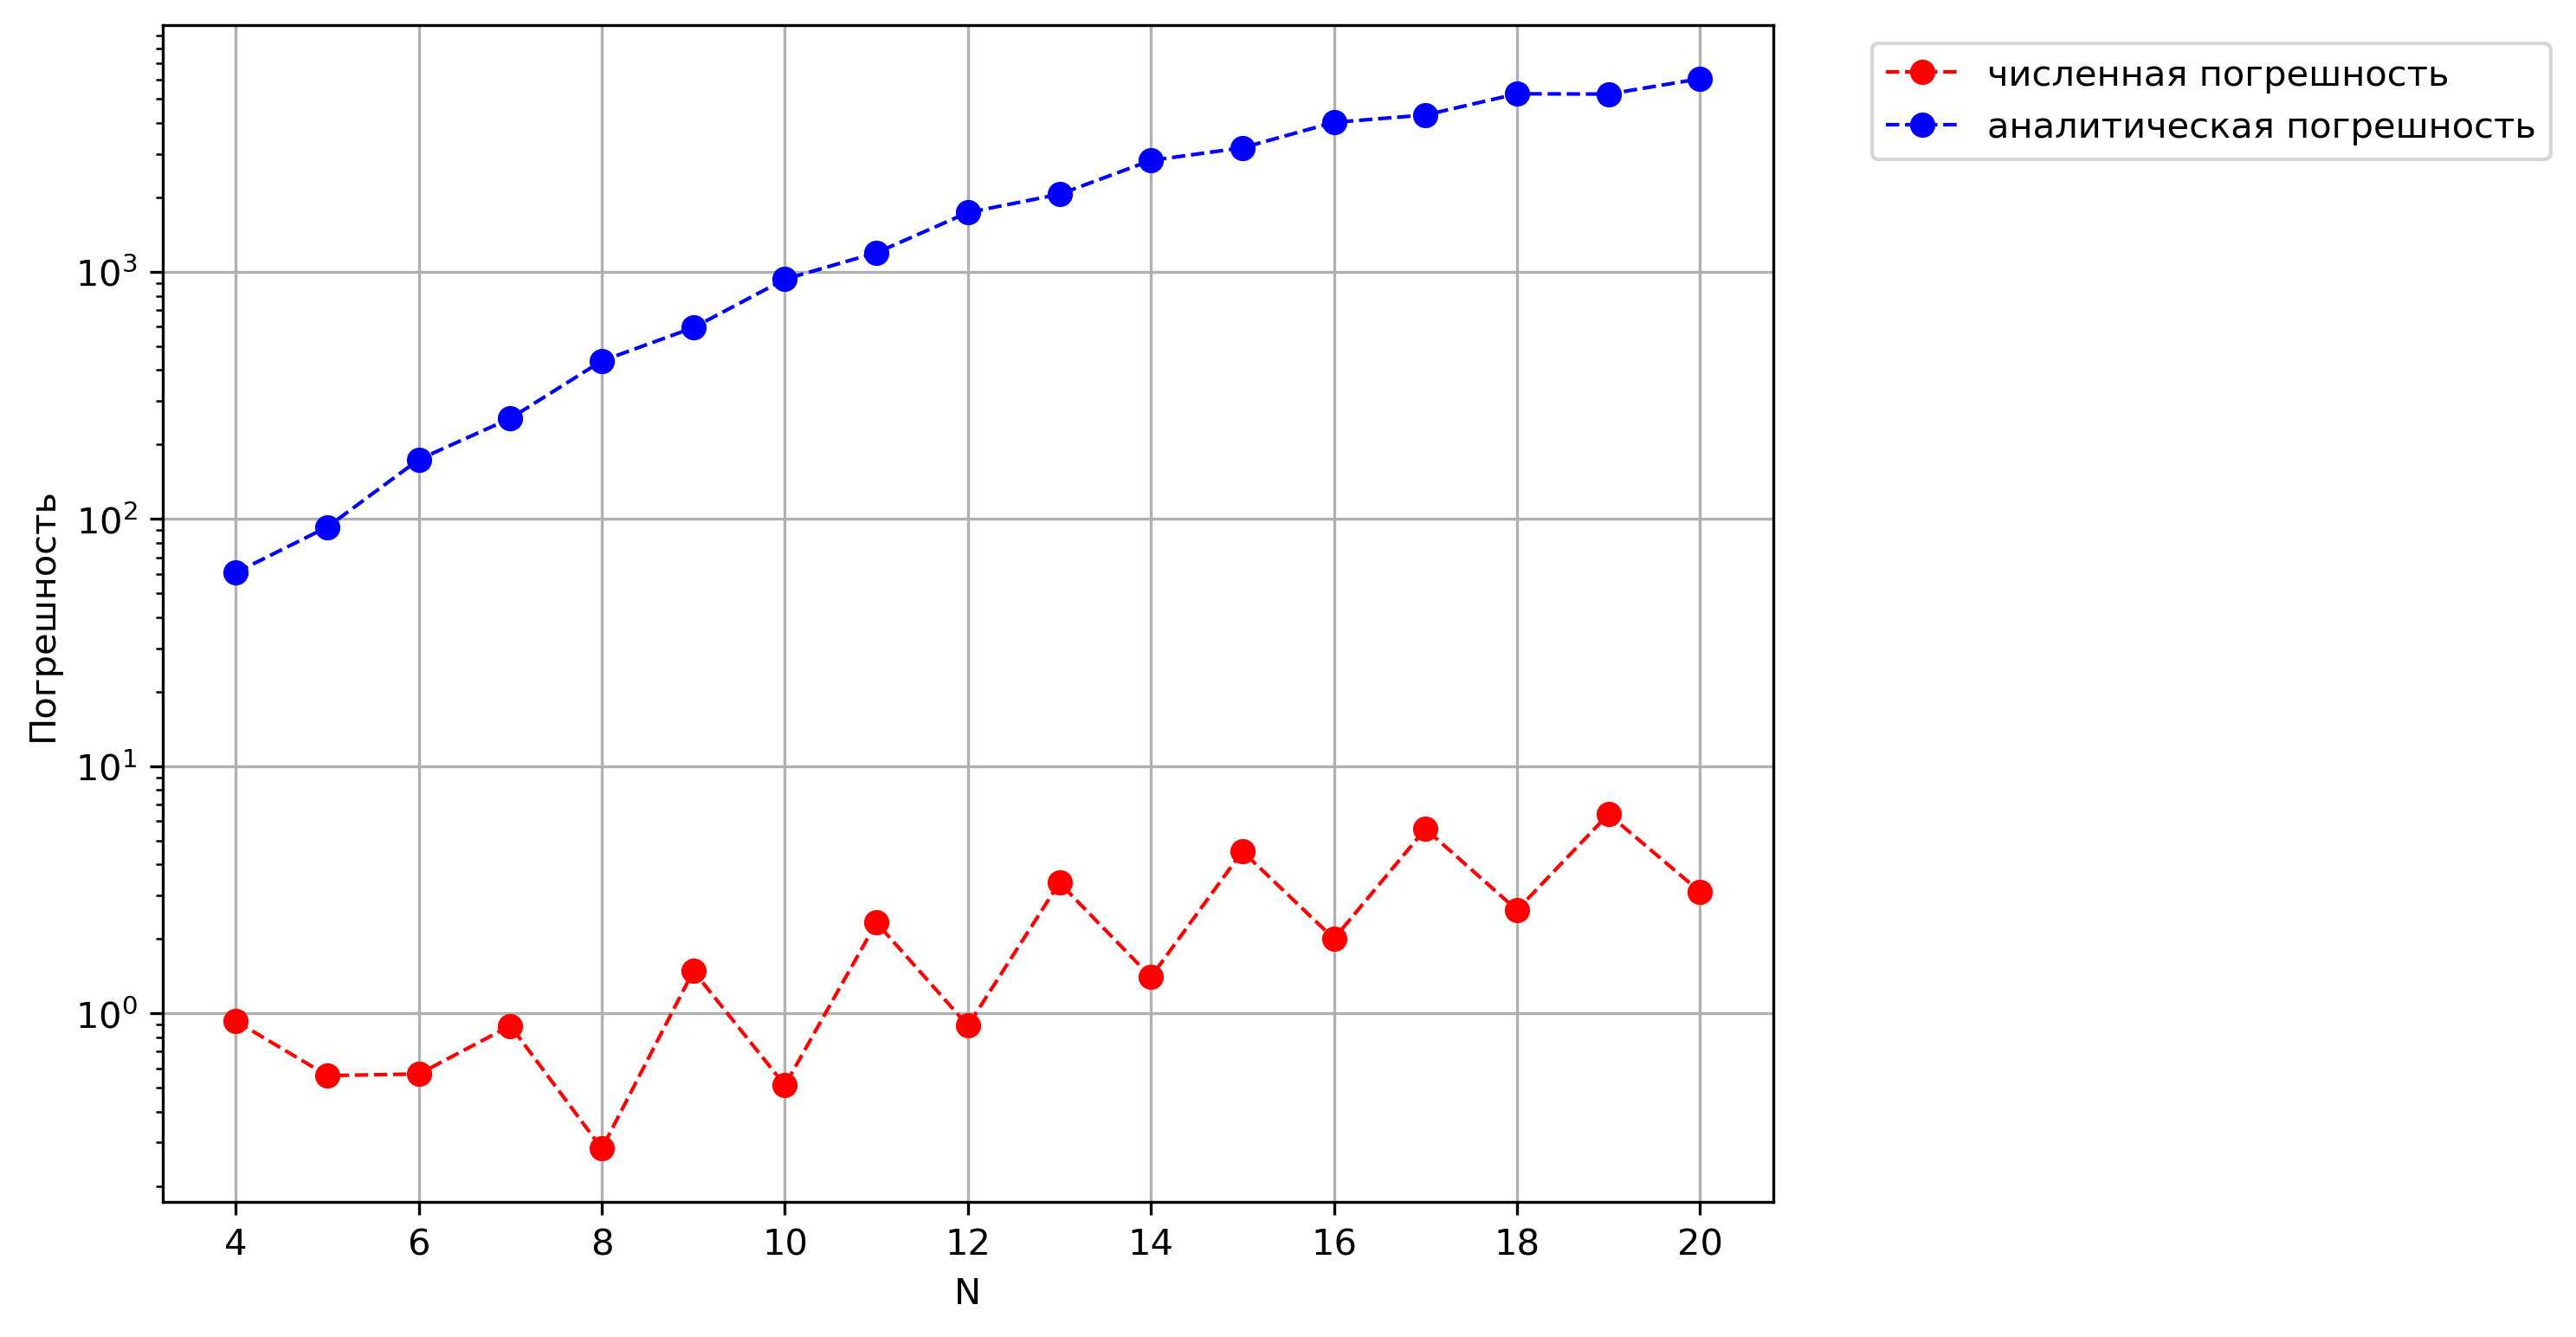

In [269]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)

axes.semilogy(N, dist_evenly_array, '--o', color="red",
              linewidth=linewidth_standart, label="численная погрешность")
axes.semilogy(N, rem_evenly_array, '--o', color="blue",
              linewidth=linewidth_standart, label="аналитическая погрешность")
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("N")
axes.set_ylabel("Погрешность")

plt.show()

## Случай оптимально распределенных узлов.

### Построение графиков заданной функции и интерполяционного полинома Лагранжа.

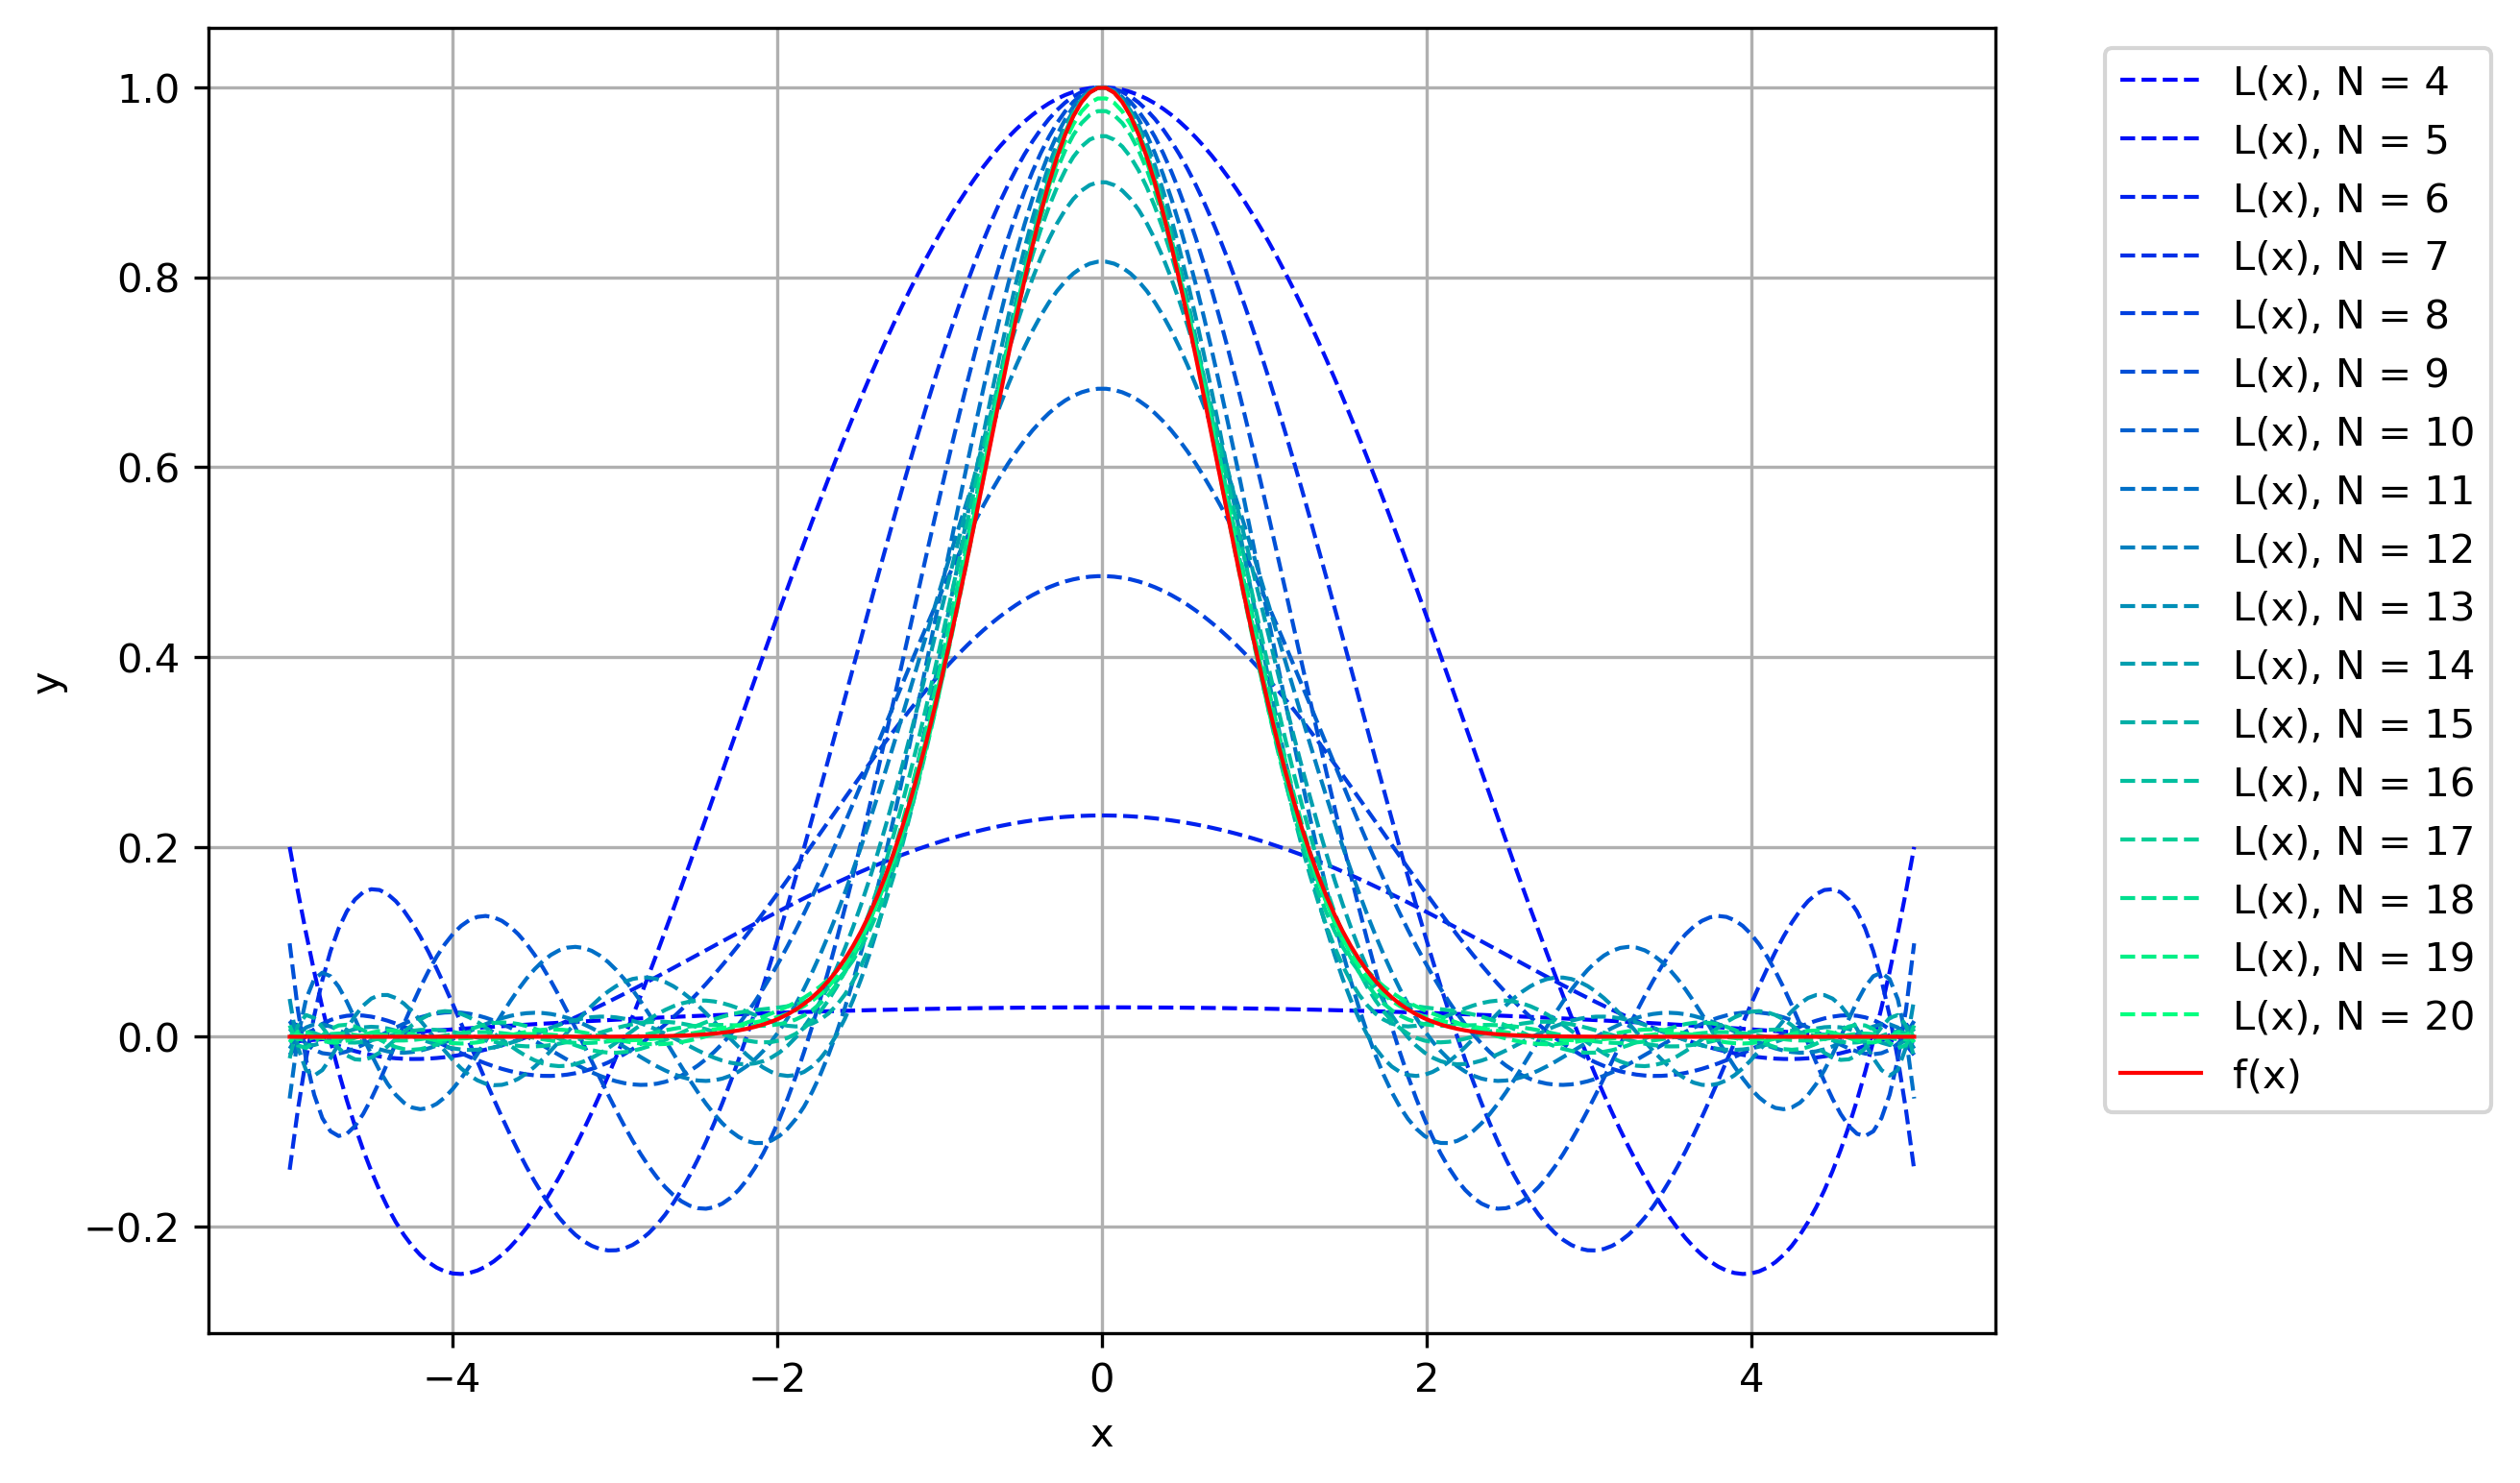

In [270]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)
cmap = plt.cm.get_cmap(cmap_name_standart, len(N))

for n in N:
    x_nodes_cheb = cheb_nodes(interval_start, interval_end, n)
    y_nodes_cheb = f(x_nodes_cheb)
    
    axes.plot(x, L(x, x_nodes_cheb, y_nodes_cheb),
              color=cmap(n - nodes_left_boundary), linestyle='--',
              linewidth=linewidth_standart, label='L(x), N = {}'.format(n))
    
axes.plot(x, fx_vec, color="red", linewidth=linewidth_standart, label='f(x)')
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("x")
axes.set_ylabel("y")

plt.show()

### Нахождение расстояния между заданной функцией и полученным интерполяционным полиномом в лебеговом пространстве.

In [271]:
dist_cheb_array = np.array([])

for n in N:
    x_nodes_cheb = cheb_nodes(interval_start, interval_end, n)
    y_nodes_cheb = f(x_nodes_cheb)
    
    distance = np.max(np.abs(fx_vec - L_vec(x=x, x_nodes=x_nodes_cheb,
                                        y_nodes=y_nodes_cheb)))
    dist_cheb_array = np.append(dist_cheb_array, distance)
    
    print("Количество узлов = {}, расстояние = {}".format(n, distance))

Количество узлов = 4, расстояние = 0.9683441027456798
Количество узлов = 5, расстояние = 0.565053480919778
Количество узлов = 6, расстояние = 0.7662996714044655
Количество узлов = 7, расстояние = 0.3581262679083945
Количество узлов = 8, расстояние = 0.514267396653969
Количество узлов = 9, расстояние = 0.19970330717074608
Количество узлов = 10, расстояние = 0.3169068681695911
Количество узлов = 11, расстояние = 0.1252371491449286
Количество узлов = 12, расстояние = 0.18307230405671393
Количество узлов = 13, расстояние = 0.07278655961218285
Количество узлов = 14, расстояние = 0.09947396926953878
Количество узлов = 15, расстояние = 0.03726198661245251
Количество узлов = 16, расстояние = 0.05089457106388173
Количество узлов = 17, расстояние = 0.018623961261578087
Количество узлов = 18, расстояние = 0.024548672575833708
Количество узлов = 19, расстояние = 0.008690706768055414
Количество узлов = 20, расстояние = 0.011178767930954736


### Оценка верхней границы зависимости погрешности интерполяции от количества узлов.

In [272]:
rem_cheb_array = np.array([])

for n in N:
    x_nodes_cheb = cheb_nodes(interval_start, interval_end, n)
    
    rem_cheb_current = rem_cheb(x, x_nodes_cheb)
    rem_cheb_array = np.append(rem_cheb_array, rem_cheb_current)
    
    print("Количество узлов = {}, остаточный член = {}".format(n, rem_cheb_current))

Количество узлов = 4, остаточный член = 0.061469182880234424
Количество узлов = 5, остаточный член = 0.016359011016416295
Количество узлов = 6, остаточный член = 0.0035624719520722034
Количество узлов = 7, остаточный член = 0.0011659808089481741
Количество узлов = 8, остаточный член = 0.0003066525617887825
Количество узлов = 9, остаточный член = 6.337745314036849e-05
Количество узлов = 10, остаточный член = 1.1886464331389091e-05
Количество узлов = 11, остаточный член = 2.8045900832803124e-06
Количество узлов = 12, остаточный член = 5.960736813691454e-07
Количество узлов = 13, остаточный член = 1.0330725390765711e-07
Количество узлов = 14, остаточный член = 1.7304038756002528e-08
Количество узлов = 15, остаточный член = 3.3013882162681964e-09
Количество узлов = 16, остаточный член = 6.047157034322196e-10
Количество узлов = 17, остаточный член = 9.161737251930187e-11
Количество узлов = 18, остаточный член = 1.3890835905629867e-11
Количество узлов = 19, остаточный член = 2.24747229217954

### Сравнение полученных расстояния и верхней границы зависимости.

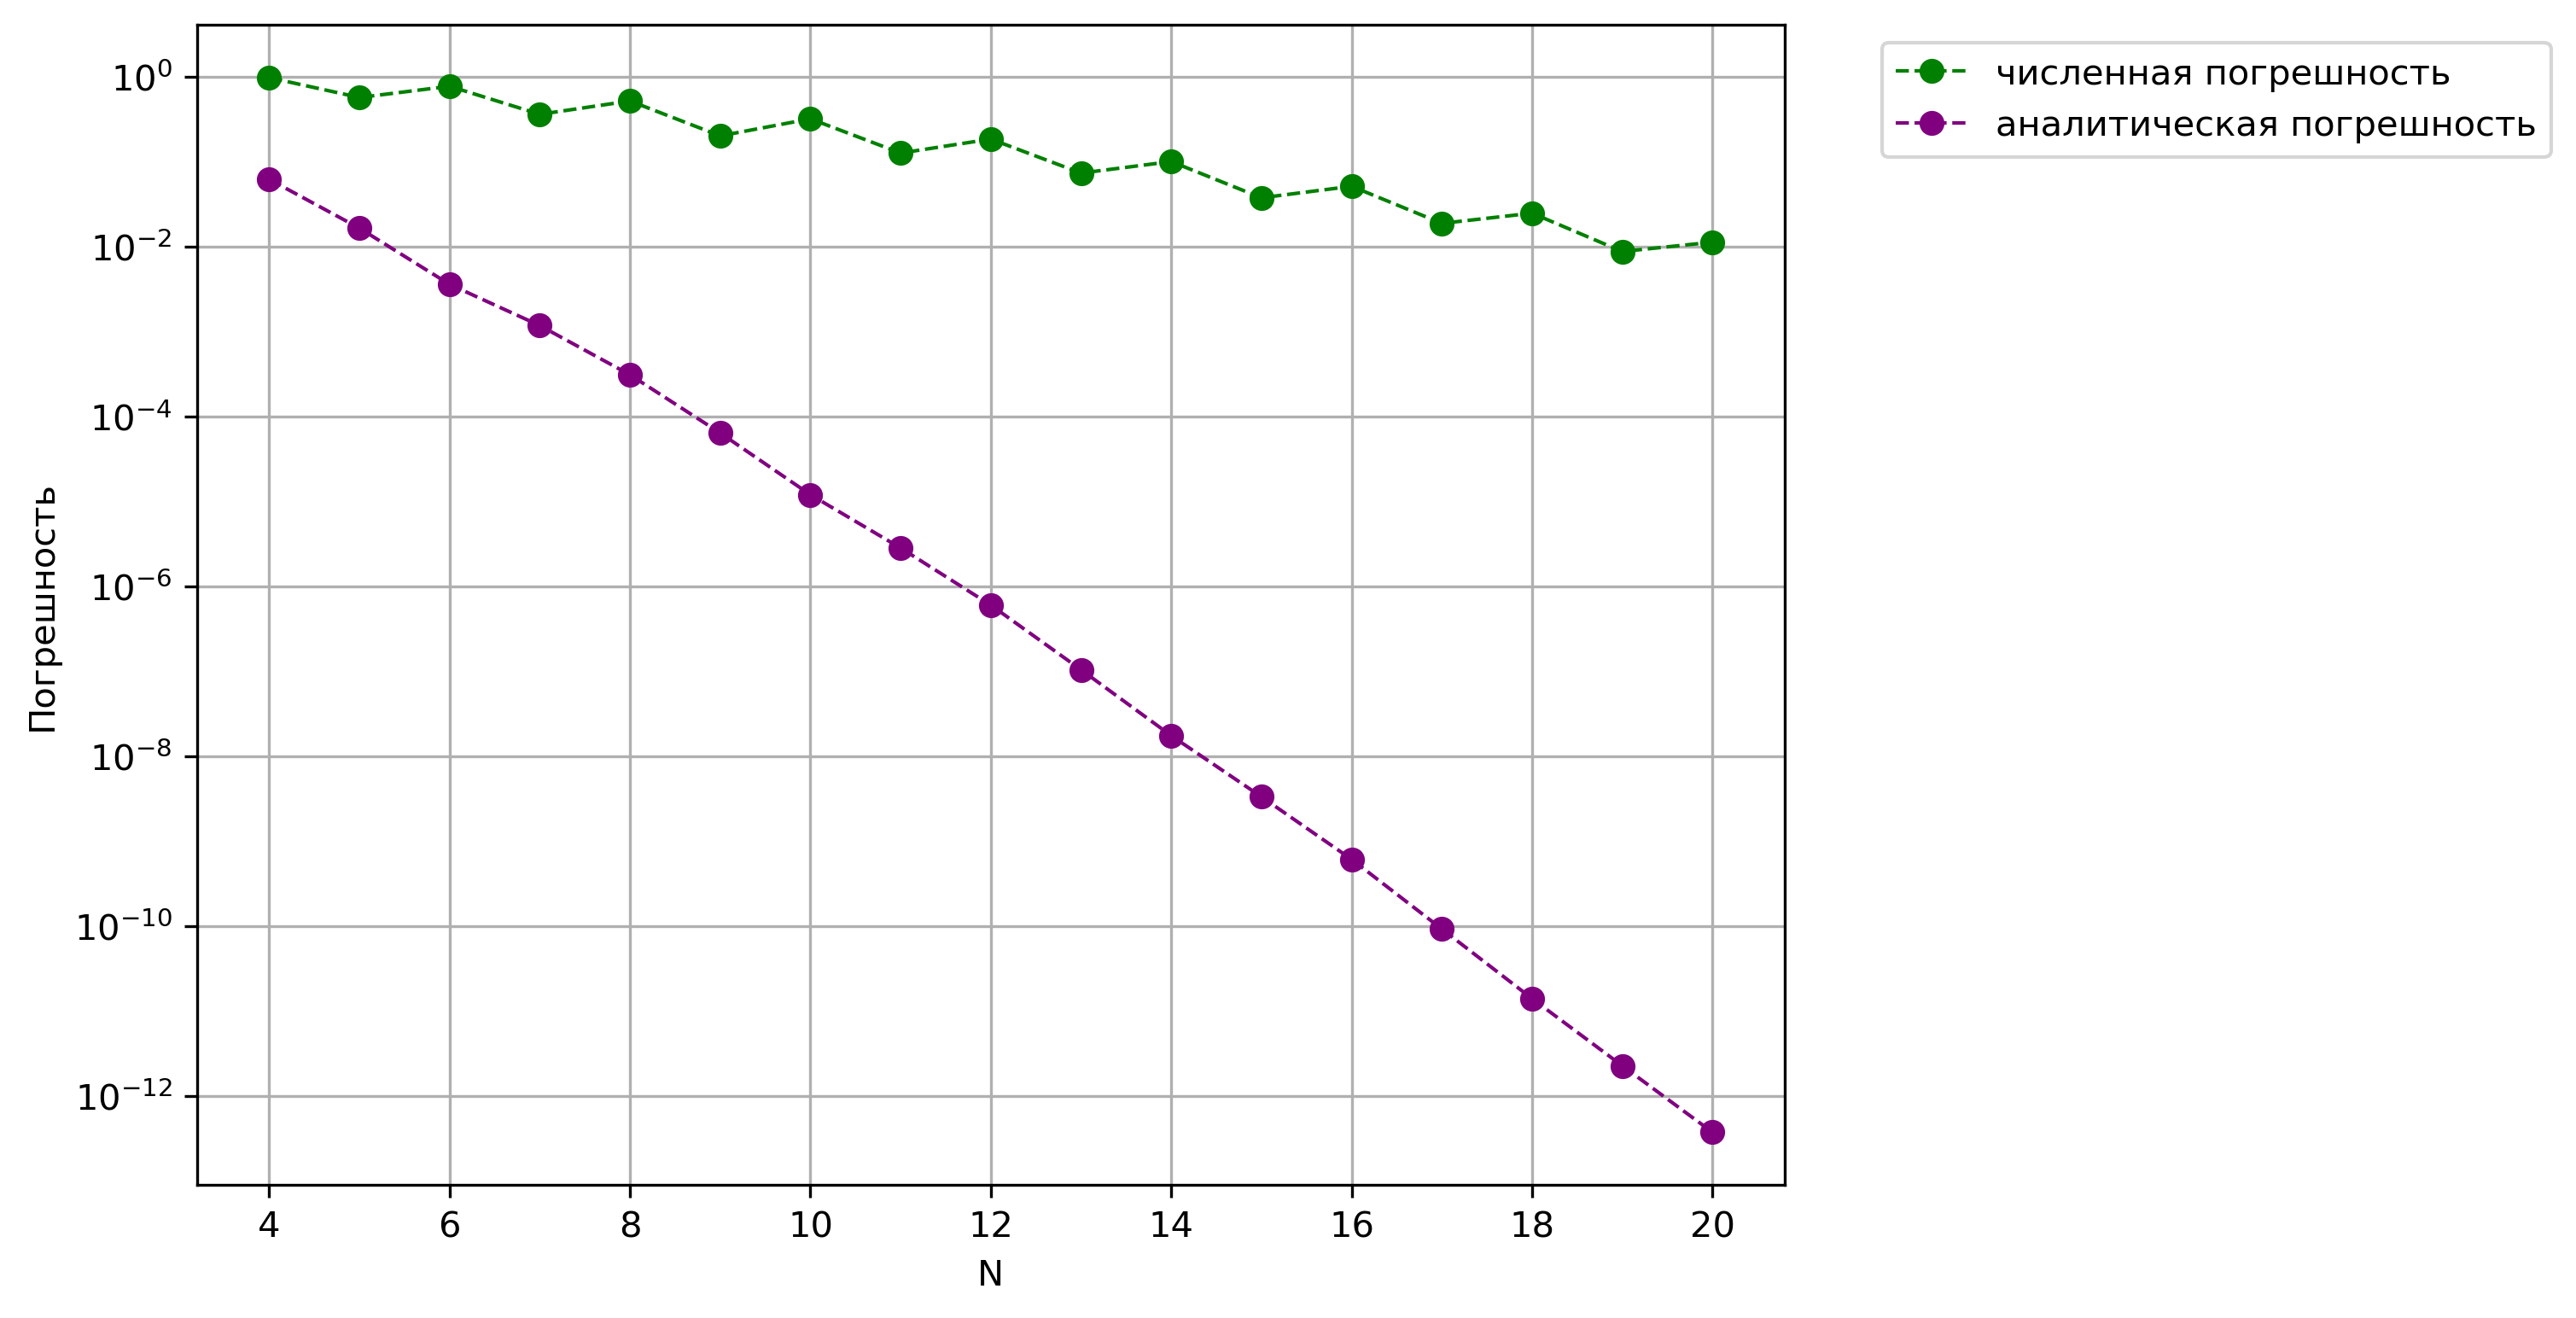

In [273]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)

axes.semilogy(N, dist_cheb_array, '--o', color="green",
              linewidth=linewidth_standart, label="численная погрешность")
axes.semilogy(N, rem_cheb_array, '--o', color="purple",
              linewidth=linewidth_standart, label="аналитическая погрешность")
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("N")
axes.set_ylabel("Погрешность")

plt.show()

## Случай кусочно-линейной интерполяции.

### Построение графиков заданной функции и интерполяционного полинома Лагранжа.

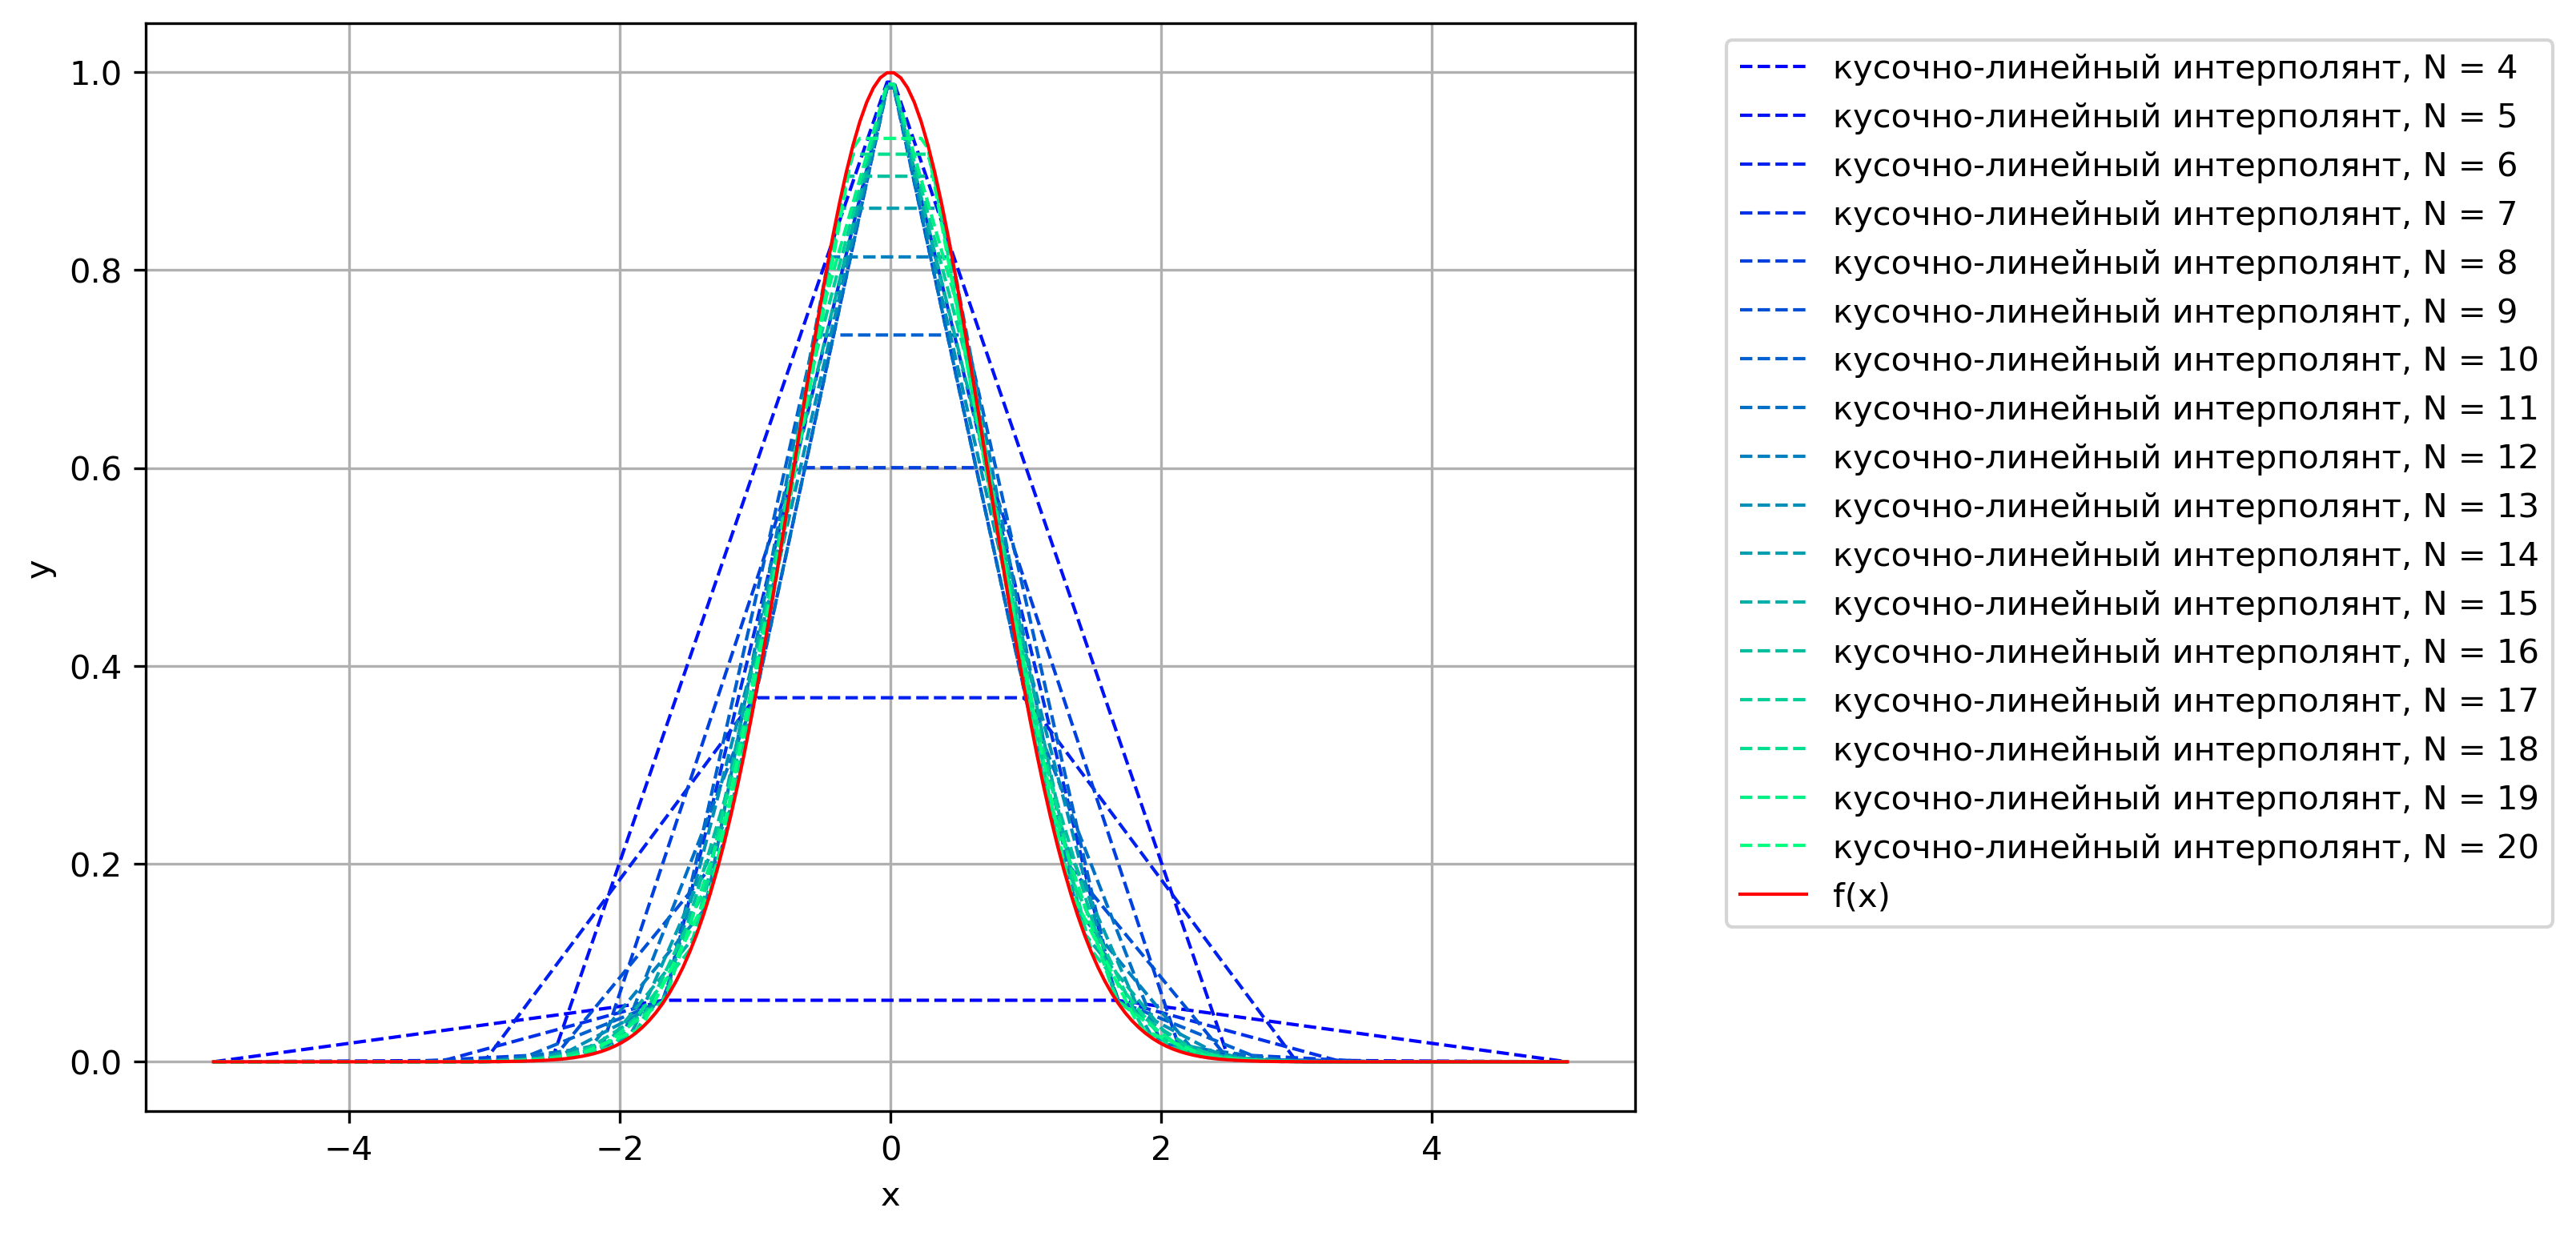

In [274]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)

cmap = plt.cm.get_cmap(cmap_name_standart, len(N))

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    y_nodes_evenly_distributed = f(x_nodes_evenly_distributed)
    
    f_piece_lin_array = f_piece_lin_vec(x=x, x_nodes=x_nodes_evenly_distributed,
                                        y_nodes=y_nodes_evenly_distributed)

    axes.plot(x, f_piece_lin_array,
              color=cmap(n - nodes_left_boundary), linestyle='--',
              linewidth=linewidth_standart, label='кусочно-линейный интерполянт, N = {}'.format(n))


axes.plot(x, fx_vec, color="red", linewidth=linewidth_standart, label='f(x)')
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("x")
axes.set_ylabel("y")

plt.show()

### Нахождение расстояния между заданной функцией и полученным интерполяционным полиномом в лебеговом пространстве.

In [275]:
dist_piece_lin_array = np.array([])

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    y_nodes_evenly_distributed = f(x_nodes_evenly_distributed)
    
    distance = np.max(np.abs(fx_vec - f_piece_lin_vec(x=x, x_nodes=x_nodes_evenly_distributed,
                                        y_nodes=y_nodes_evenly_distributed)))
    
    dist_piece_lin_array = np.append(dist_piece_lin_array, distance)
    
    print("Количество узлов = {}, расстояние = {}".format(n, distance))

Количество узлов = 4, расстояние = 0.9371923780145637
Количество узлов = 5, расстояние = 0.3001745971576101
Количество узлов = 6, расстояние = 0.6314894608652376
Количество узлов = 7, расстояние = 0.08759133762416946
Количество узлов = 8, расстояние = 0.39899586083827565
Количество узлов = 9, расстояние = 0.10589305647798108
Количество узлов = 10, расстояние = 0.2649252301069486
Количество узлов = 11, расстояние = 0.1058213235192258
Количество узлов = 12, расстояние = 0.18603338968684124
Количество узлов = 13, расстояние = 0.09503892799135516
Количество узлов = 14, расстояние = 0.13687654720815945
Количество узлов = 15, расстояние = 0.08154894186918804
Количество узлов = 16, расстояние = 0.10452958522231026
Количество узлов = 17, расстояние = 0.06945372333969968
Количество узлов = 18, расстояние = 0.08223811345873211
Количество узлов = 19, расстояние = 0.058568572290396914
Количество узлов = 20, расстояние = 0.06627746302210413


### Оценка верхней границы зависимости погрешности интерполяции от количества узлов.

In [276]:
rem_piece_lin_array = np.array([])

for n in N:
    x_nodes_evenly_distributed = np.linspace(interval_start, interval_end, n)
    
    rem_piece_lin_current = rem_piece_lin(x, x_nodes_evenly_distributed)
    rem_piece_lin_array = np.append(rem_piece_lin_array, rem_piece_lin_current)
    
    print("Количество узлов = {}, остаточный член = {}".format(n, rem_piece_lin_current))

Количество узлов = 4, остаточный член = 1.23336749217252
Количество узлов = 5, остаточный член = 0.6937692143470424
Количество узлов = 6, остаточный член = 0.44401229718210716
Количество узлов = 7, остаточный член = 0.30834187304313
Количество узлов = 8, остаточный член = 0.22653688631740163
Количество узлов = 9, остаточный член = 0.1734423035867606
Количество узлов = 10, остаточный член = 0.13704083246361334
Количество узлов = 11, остаточный член = 0.11100307429552679
Количество узлов = 12, остаточный член = 0.09173807793018741
Количество узлов = 13, остаточный член = 0.0770854682607825
Количество узлов = 14, остаточный член = 0.06568229248256023
Количество узлов = 15, остаточный член = 0.056634221579350406
Количество узлов = 16, остаточный член = 0.049334699686900796
Количество узлов = 17, остаточный член = 0.04336057589669015
Количество узлов = 18, остаточный член = 0.03840936826834837
Количество узлов = 19, остаточный член = 0.034260208115903336
Количество узлов = 20, остаточный чл

### Сравнение полученных расстояния и верхней границы зависимости.

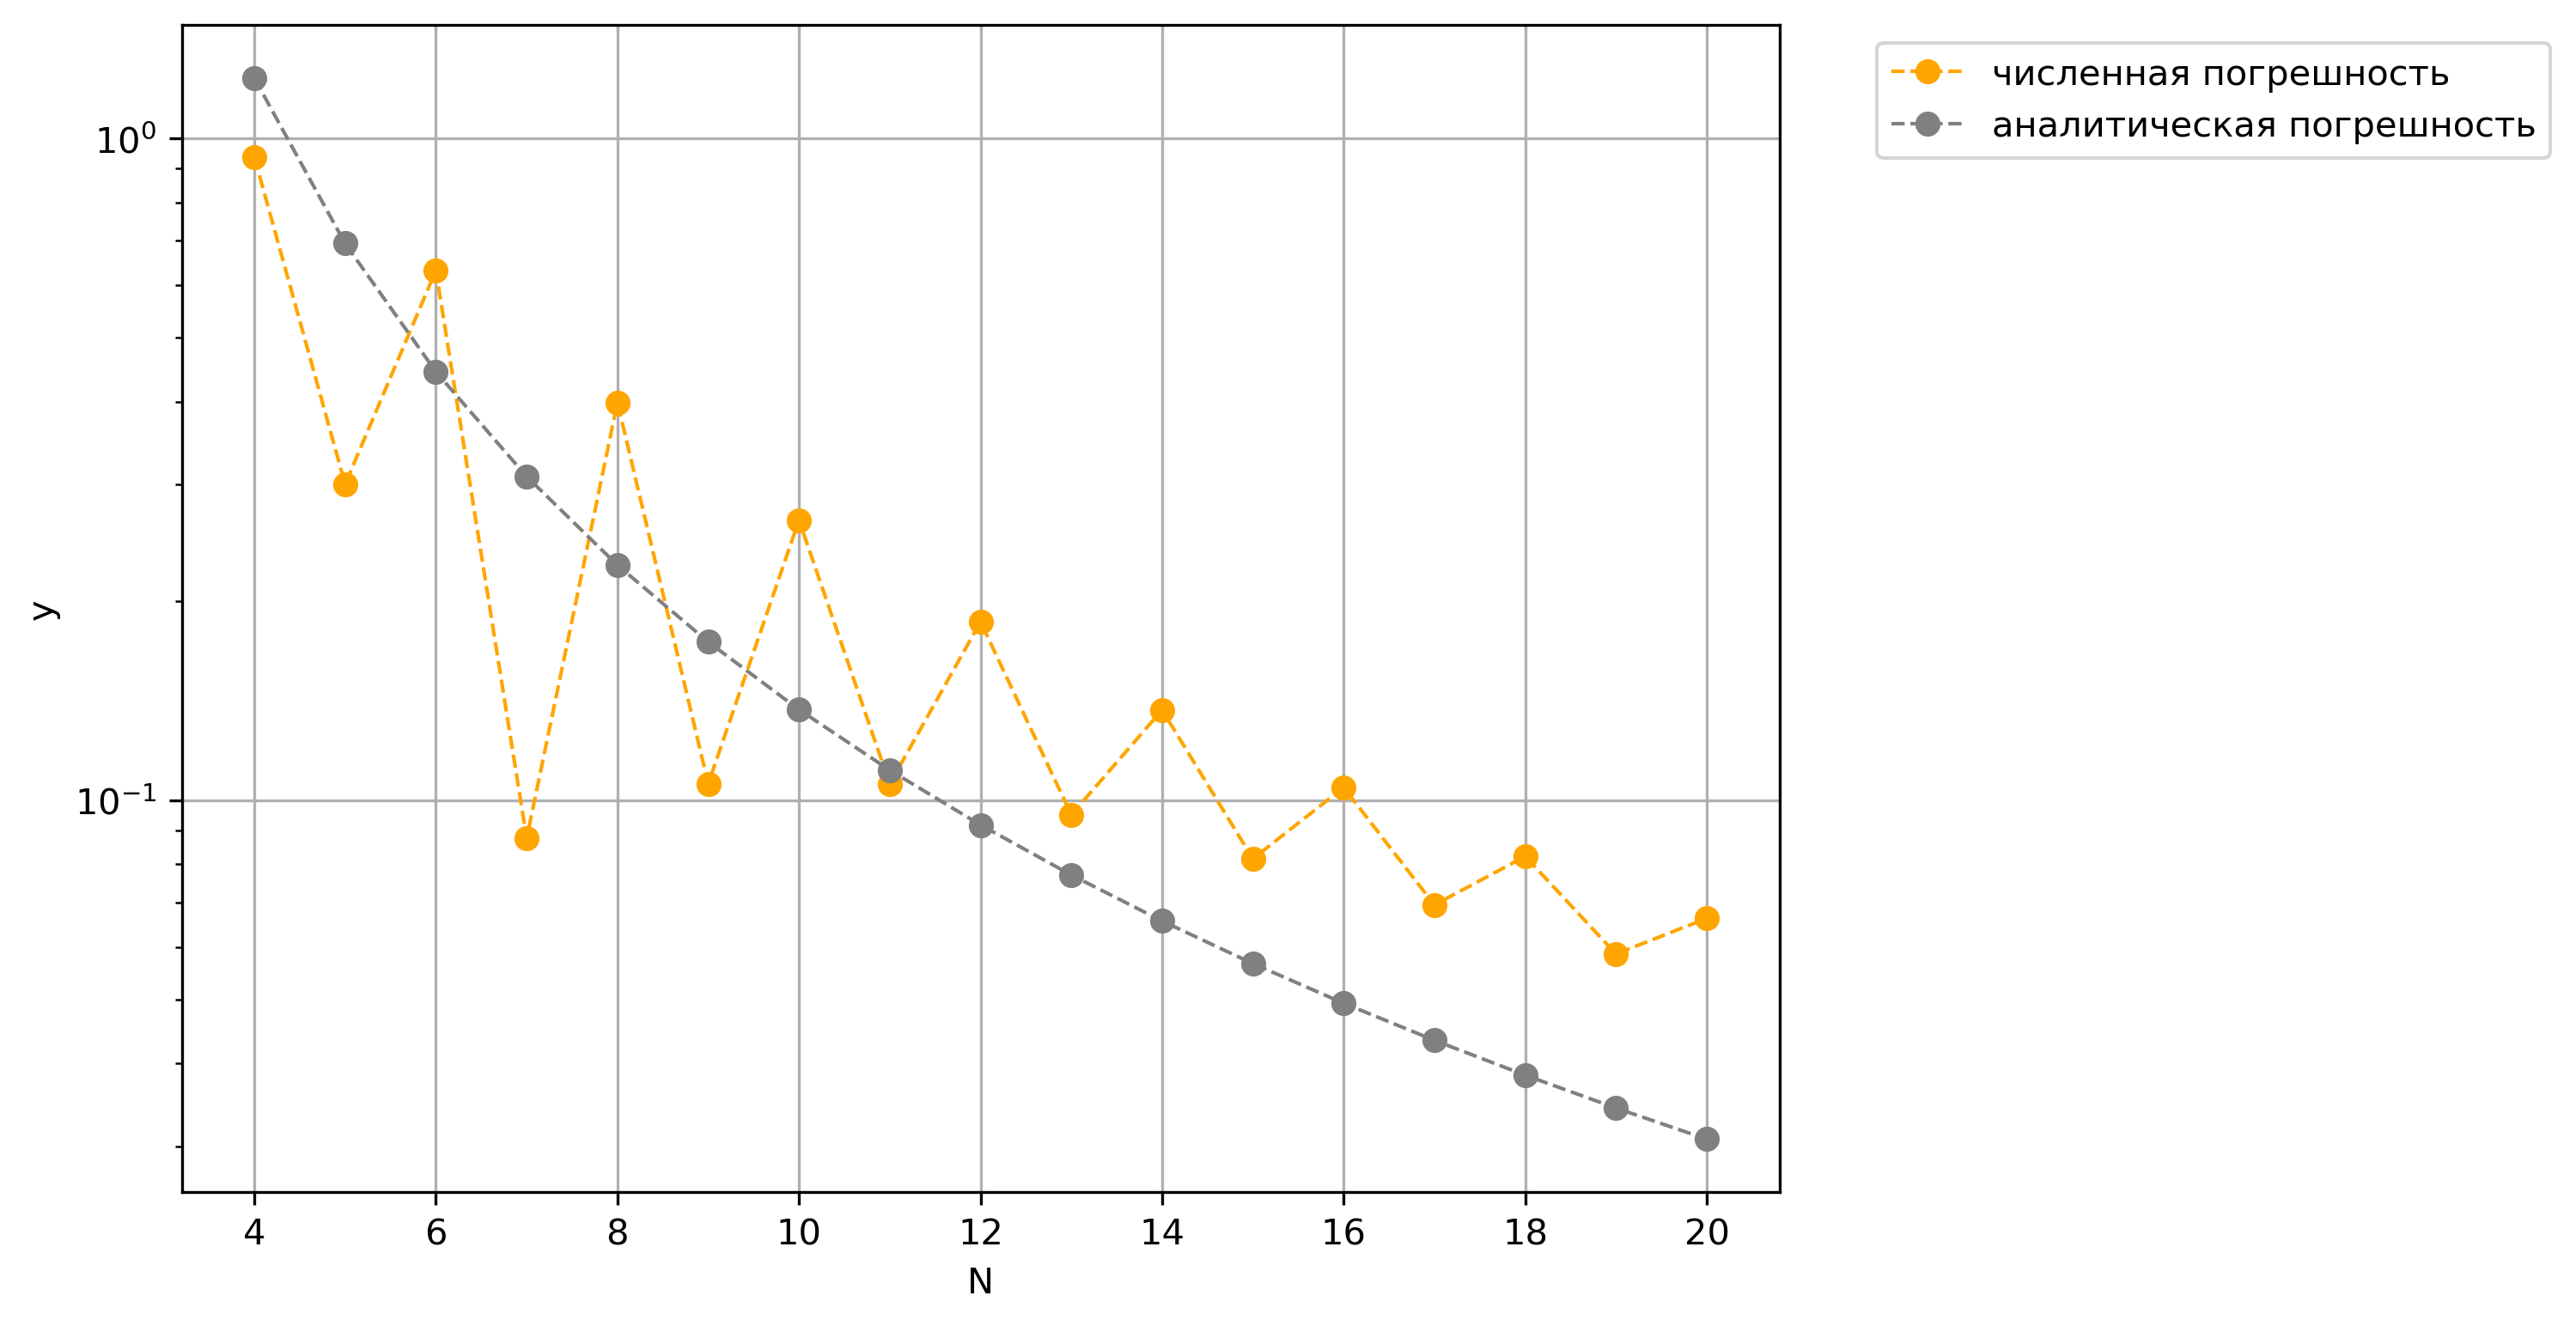

In [277]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)
axes.semilogy(N, dist_piece_lin_array, '--o', color="orange",
              linewidth=linewidth_standart, label="численная погрешность")
axes.semilogy(N, rem_piece_lin_array, '--o', color="grey",
              linewidth=linewidth_standart, label="аналитическая погрешность")
axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("N")
axes.set_ylabel("y")

plt.show()

## Вывод зависимости расстояния в лебеговом пространстве от количества узлов для трех случаев интерполяции.

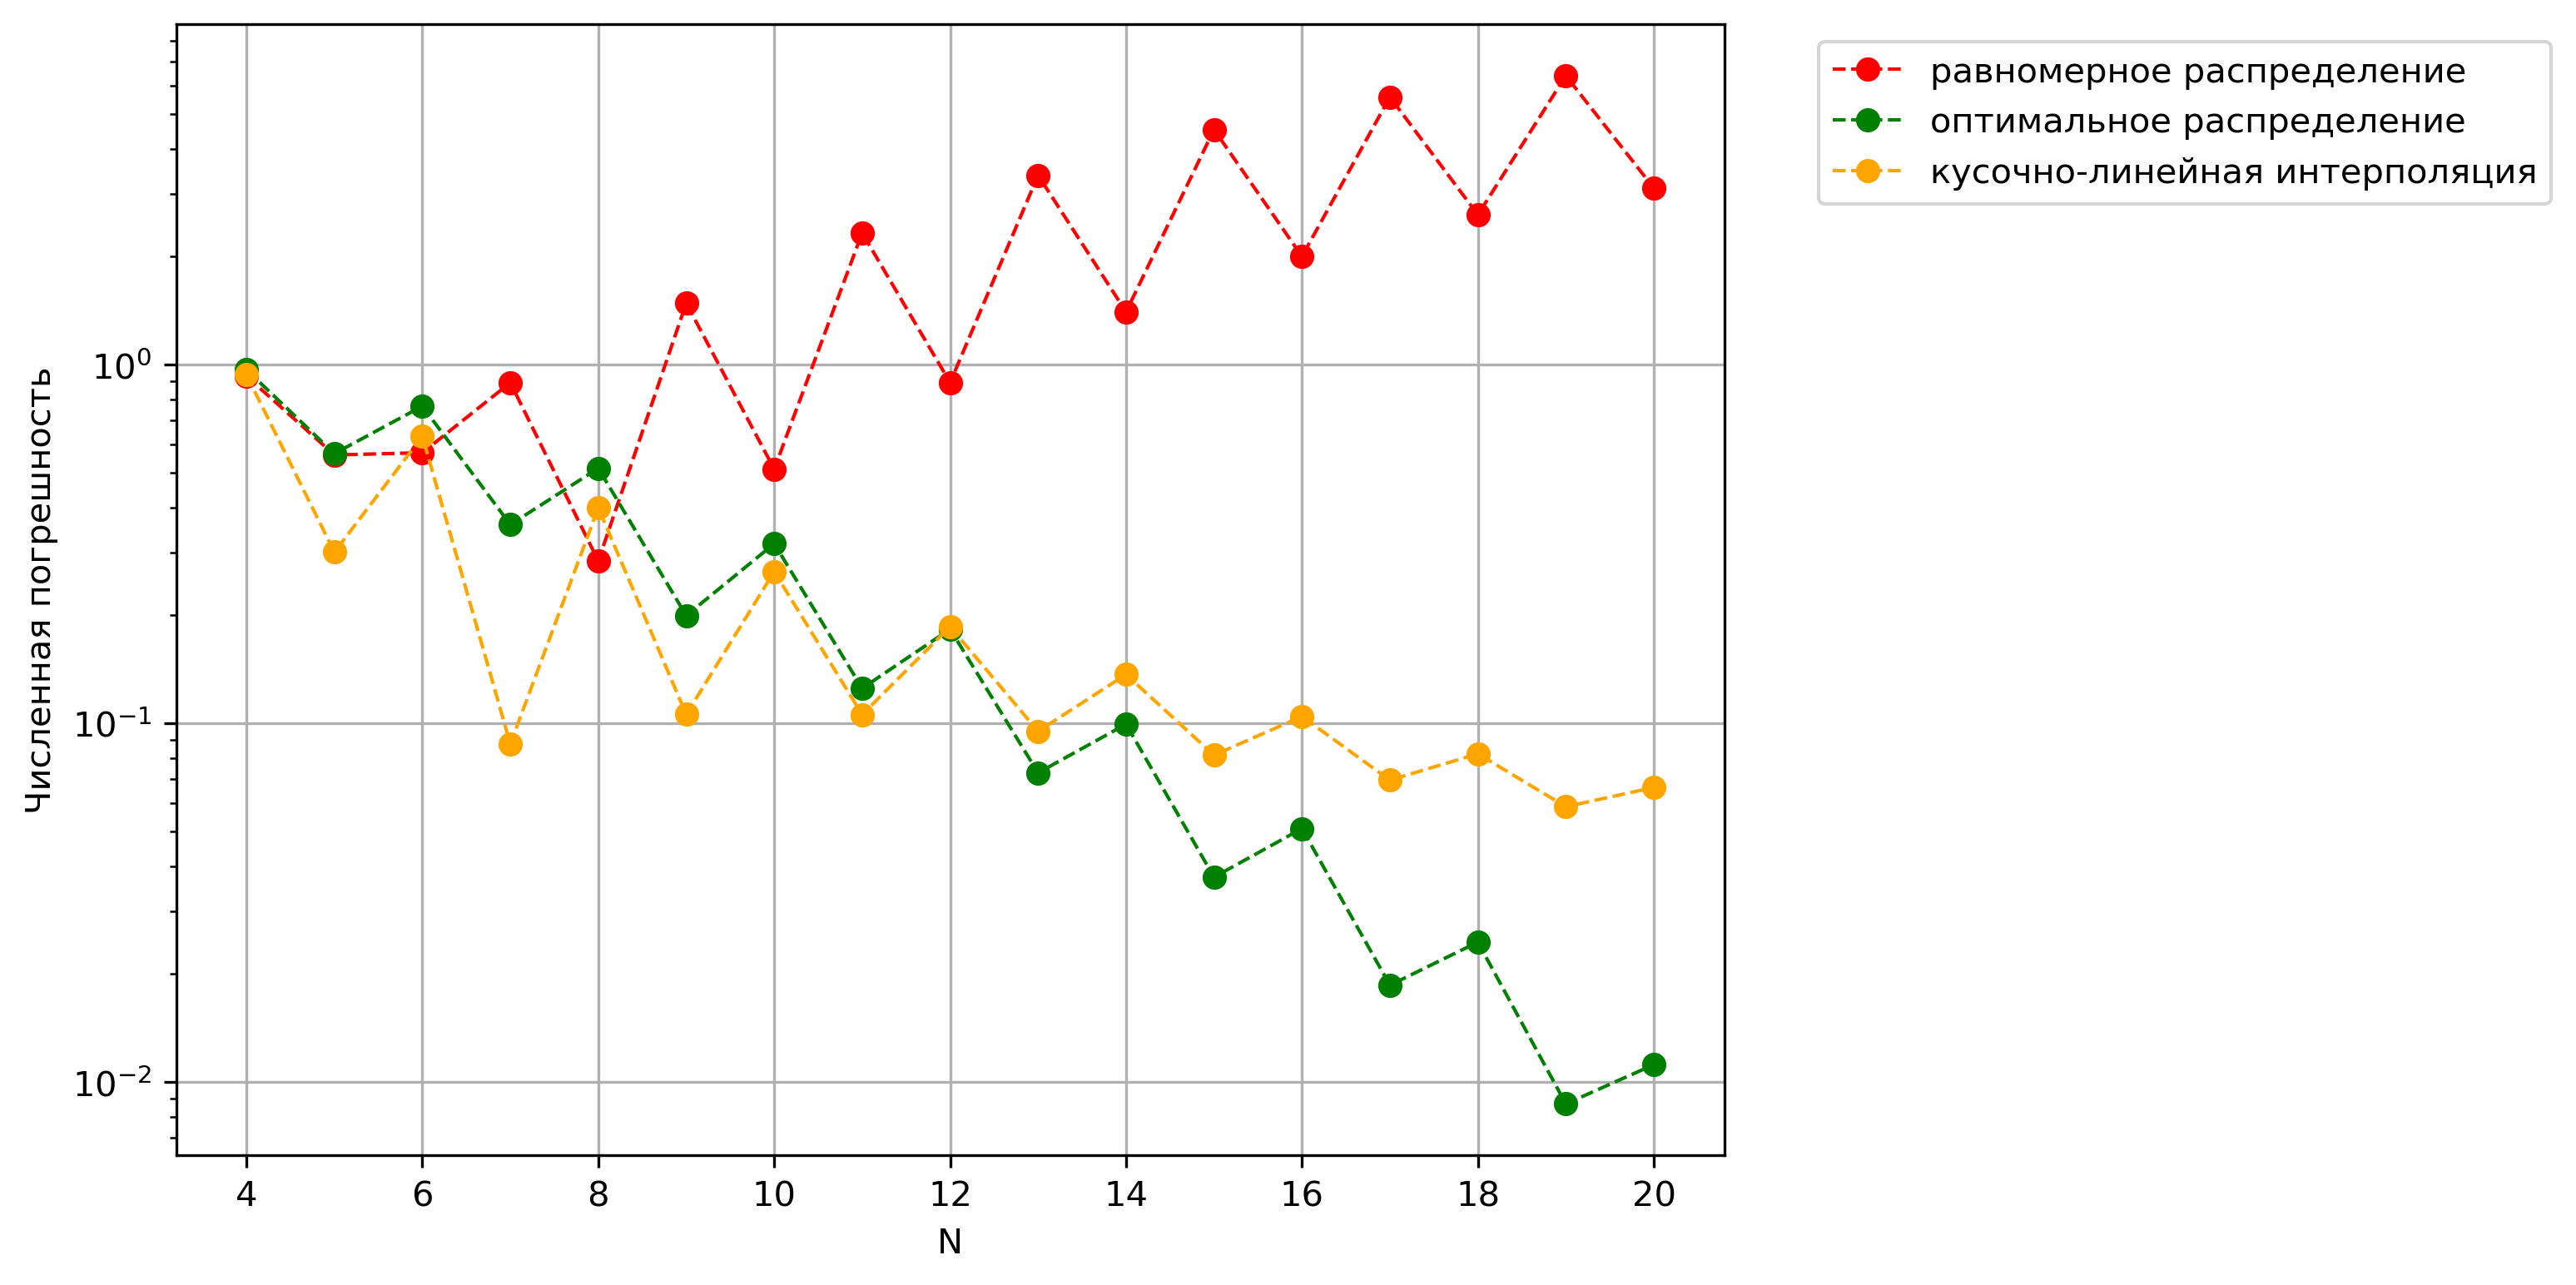

In [278]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)

axes.semilogy(N, dist_evenly_array, '--o', color="red",
              linewidth=linewidth_standart, label="равномерное распределение")
axes.semilogy(N, dist_cheb_array, '--o', color="green",
              linewidth=linewidth_standart, label="оптимальное распределение")
axes.semilogy(N, dist_piece_lin_array, '--o', color="orange",
              linewidth=linewidth_standart, label="кусочно-линейная интерполяция")

axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("N")
axes.set_ylabel("Численная погрешность")

plt.show()

## Функция ошибок.

### Поиск приближеннного значения функции ошибок. 

In [279]:
f_err_values = np.array([])

for n in N_err:
    f_err_interp_value = f_err_interp(n)
    f_err_values = np.append(f_err_values, f_err_interp_value)

    print("Количество узлов = {}, значение функции ошибок = {}".format(n, f_err_interp_value))

Количество узлов = 3, значение функции ошибок = 1.148868662915597
Количество узлов = 5, значение функции ошибок = 0.9894786273863142
Количество узлов = 7, значение функции ошибок = 0.992333444868329
Количество узлов = 9, значение функции ошибок = 0.9935191271271684


### Поиск значения функции ошибок из модуля scipy.

In [280]:
f_err_spec_values = np.array([])

for n in N_err_special:
    f_err_spec_value = erf(2)
    f_err_spec_values = np.append(f_err_spec_values, f_err_spec_value)

    print("Количество узлов = {}, значение функции ошибок из модуля scipy = {}".format(n, f_err_interp_value))

Количество узлов = 3, значение функции ошибок из модуля scipy = 0.9935191271271684
Количество узлов = 4, значение функции ошибок из модуля scipy = 0.9935191271271684
Количество узлов = 5, значение функции ошибок из модуля scipy = 0.9935191271271684
Количество узлов = 6, значение функции ошибок из модуля scipy = 0.9935191271271684
Количество узлов = 7, значение функции ошибок из модуля scipy = 0.9935191271271684
Количество узлов = 8, значение функции ошибок из модуля scipy = 0.9935191271271684
Количество узлов = 9, значение функции ошибок из модуля scipy = 0.9935191271271684


### Построение графика полученной зависимости значения функции ошибок от количества узлов. 

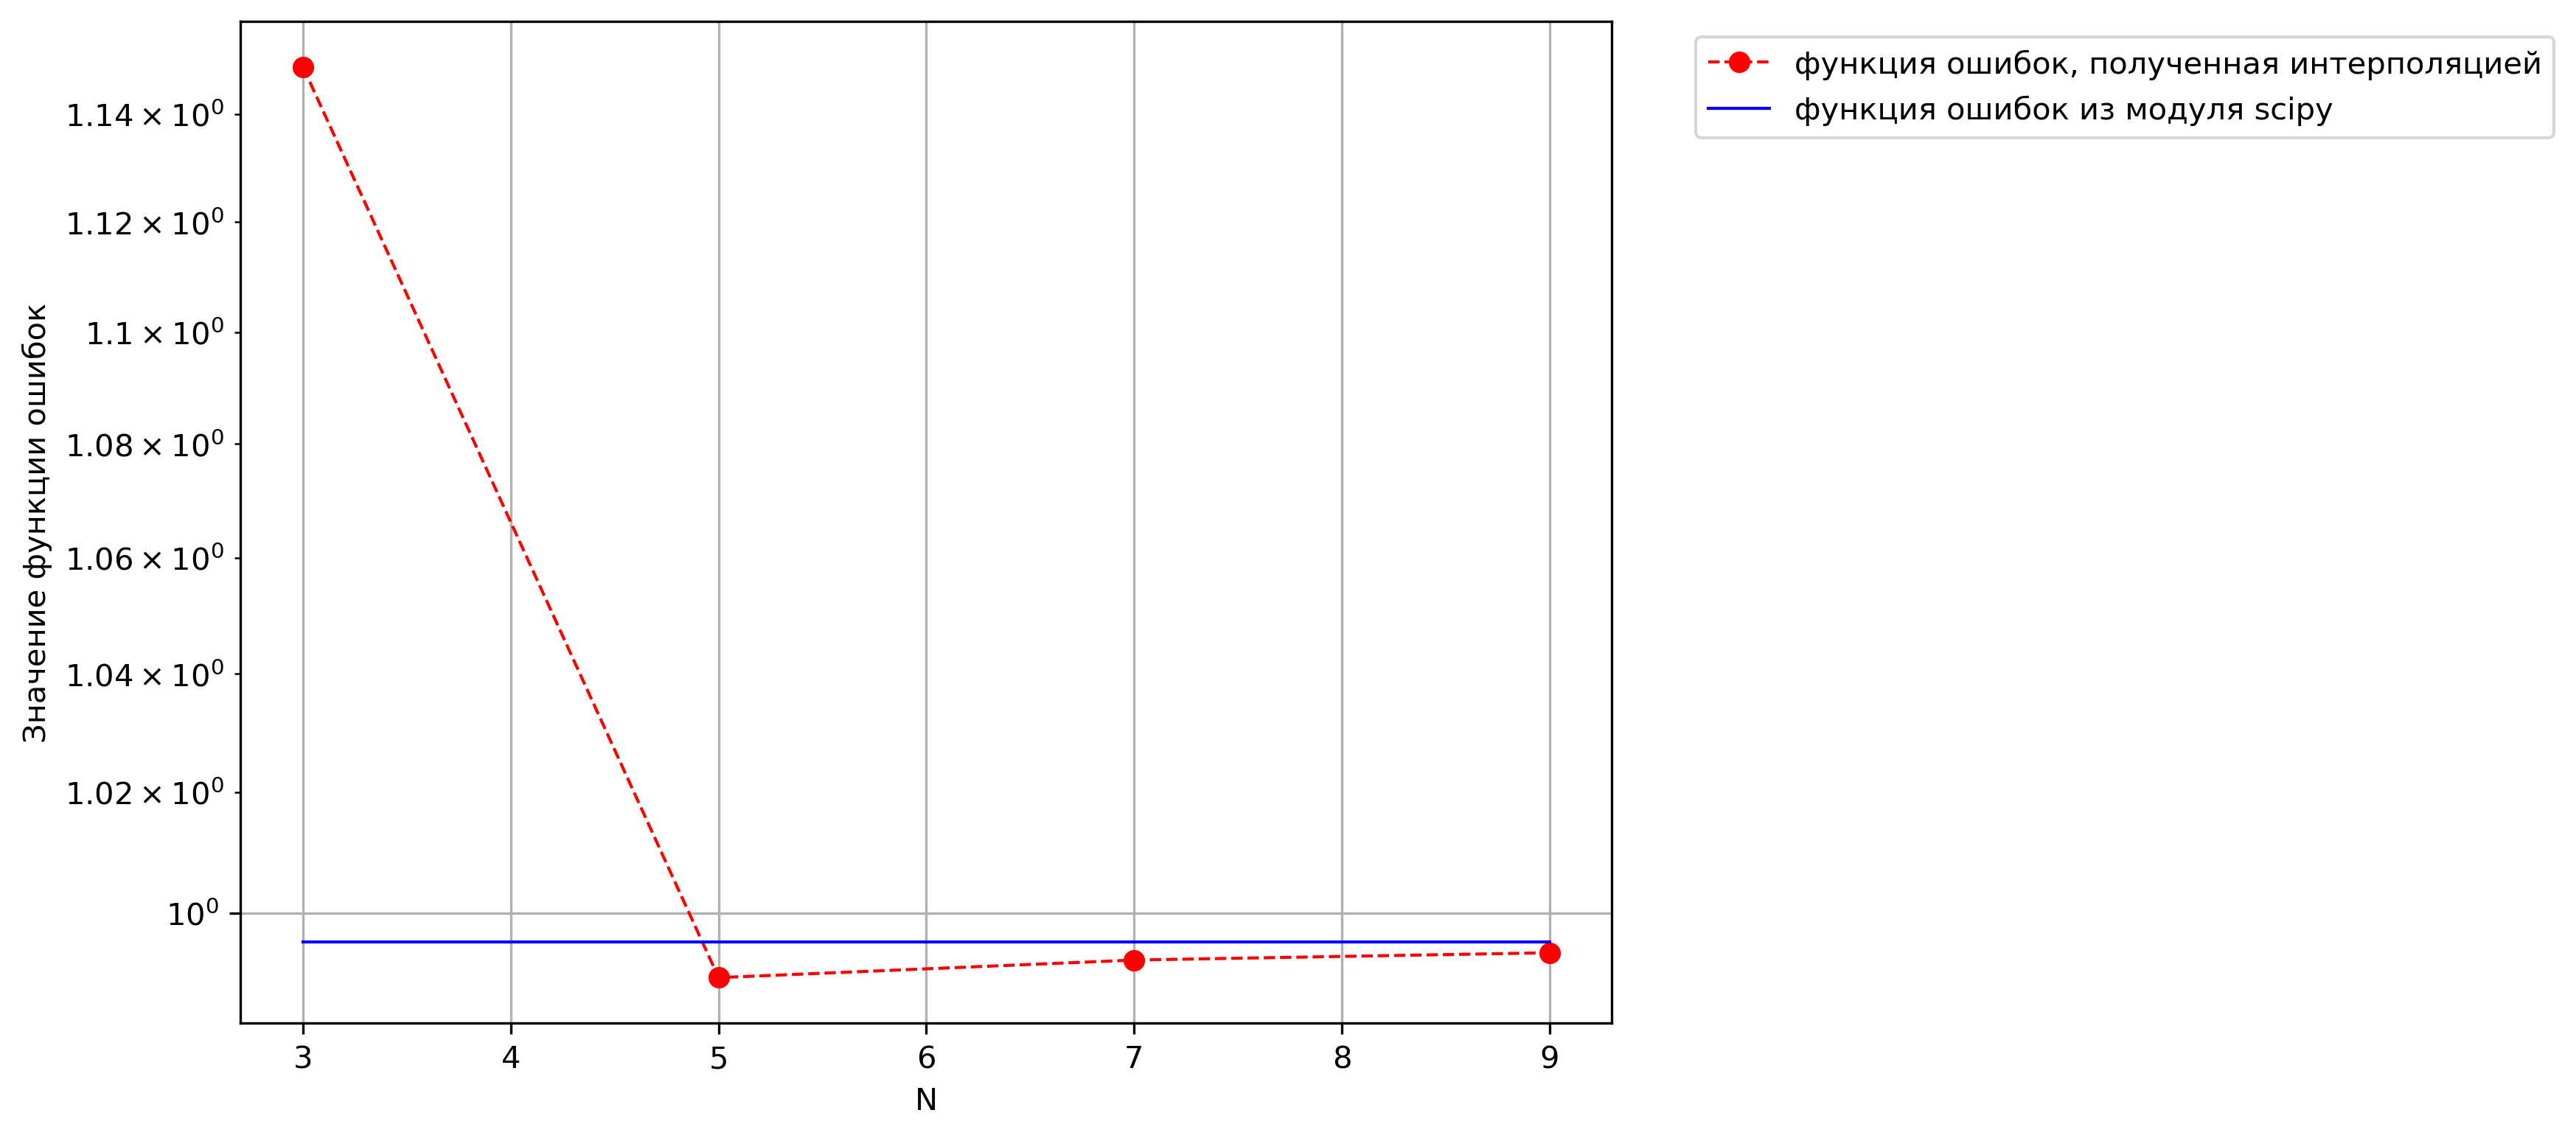

In [281]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize_standart, dpi=dpi_standart)

axes.semilogy(N_err, f_err_values, '--o', color="red",
              linewidth=linewidth_standart, label="функция ошибок, полученная интерполяцией")
axes.semilogy(N_err_special, f_err_spec_values, color="blue",
              linewidth=linewidth_standart, label="функция ошибок из модуля scipy")

axes.grid()

axes.legend(bbox_to_anchor=bbox_to_anchor_standart, loc='upper left')
axes.set_xlabel("N")
axes.set_ylabel("Значение функции ошибок")

plt.show()